# A Neural Probabilistic Language Model

In [1]:
# import key packages
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# retina display
%config InlineBackend.figure_format = 'retina'

In [3]:
# read the dataset
words = open('./data/names.txt', 'r').read().splitlines()
print('Number of words:', len(words))

Number of words: 32033


In [5]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
# build up the dictionary for mapping characters to integers
chars = sorted(list(set(''.join(words))))
print('Number of characters:', len(chars))
# chars to integers
char2int = {c: i+1 for i, c in enumerate(chars)}
# add . as the padding character
char2int['.'] = 0
# integers to chars
int2char = {i: c for c, i in char2int.items()}

Number of characters: 26


In [10]:
print('char2int:', char2int)

char2int: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [12]:
print('int2char:', int2char)

int2char: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [13]:
# build up the dataset
block_size = 3 # the length of sequences of input data
X, Y = [], []

for word in words[:5]:
    print(word)
    for i in range(0, len(word) - block_size):
        # rolling window of block_size
        X.append([char2int[c] for c in word[i:i+block_size]])
        Y.append(char2int[word[i+block_size]])
        print('  ', word[i:i+block_size], '-->', word[i+block_size])

emma
   emm --> a
olivia
   oli --> v
   liv --> i
   ivi --> a
ava
isabella
   isa --> b
   sab --> e
   abe --> l
   bel --> l
   ell --> a
sophia
   sop --> h
   oph --> i
   phi --> a


In [16]:
# the above method does not add '.'
block_size = 3 # the length of sequences of input data
X, Y = [], []

for word in words[:5]:
    print(word)
    # initial context by building up the padding characters
    context = [0] * block_size
    for ch in word+ '.':
        idx = char2int[ch]
        X.append(context)
        Y.append(idx)
        # print the context and the next character
        print(''.join([int2char[i] for i in context]), '-->', ch)
        # update the context by rolling
        context = context[1:] + [idx]

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [18]:
# convert to tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

In [20]:
# right now 32 = document size, 3 = block size
print(X.shape, Y.shape, X.dtype, Y.dtype)

torch.Size([32, 3]) torch.Size([32]) torch.int64 torch.int64


In [22]:
print(X[:5], Y[:5])

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]]) tensor([ 5, 13, 13,  1,  0])


In [24]:
# initialize the lookup table
C_lookup = torch.randn(len(char2int), 2, requires_grad=True)
print(C_lookup.shape)

torch.Size([27, 2])


In [25]:
C_lookup

tensor([[ 0.4977,  0.8756],
        [-0.4006,  0.6435],
        [ 1.7300, -0.0446],
        [ 0.0446, -2.9870],
        [ 1.9398, -0.2666],
        [ 0.0790, -0.2298],
        [ 2.2499, -2.9052],
        [ 1.3151,  0.2223],
        [-0.1359,  1.1480],
        [ 1.0357, -0.6063],
        [ 0.1686, -1.5691],
        [ 0.4391, -1.6887],
        [ 0.2008, -1.5794],
        [ 0.7514, -0.3242],
        [-0.2992,  0.0307],
        [-0.3125, -0.0838],
        [ 0.5809,  1.7678],
        [ 1.1271,  0.8043],
        [ 0.3943, -1.1657],
        [-0.4073,  2.0113],
        [-0.6337, -0.0362],
        [ 0.7606,  0.8676],
        [-0.5598,  1.4374],
        [-0.9409,  0.4591],
        [ 0.0696,  0.4772],
        [-0.2564,  0.0926],
        [-0.1636, -1.1153]], requires_grad=True)

Now, it's time to have some reflections. Since we are doing a sequence to sequence model. We first need to construct our sequences:

- choosing input block size as 3 (rolling window)
- choosing output size as 1 (next word)

After that, we constructed our look-up table, which is an embedding layer. The embedding layer is a matrix of size (vocab_size, embedding_size). The embedding_size is a hyperparameter. In our case we have 

- vocab_size = 27
- embedding_size = 2 (to keep it simple)

Since each input sequence has 3 words, we have 3 embedding vectors.

In [27]:
# example of getting embedding vectors
print(C_lookup[0])
print(C_lookup[[3, 5, 9]])

tensor([0.4977, 0.8756], grad_fn=<SelectBackward0>)
tensor([[ 0.0446, -2.9870],
        [ 0.0790, -0.2298],
        [ 1.0357, -0.6063]], grad_fn=<IndexBackward0>)


In [30]:
# embedding all the characters in the input sequences
X_embed = C_lookup[X]
print(X_embed.shape)

torch.Size([32, 3, 2])


In [35]:
# create the hidden layer
# input dimension = 2x3 = 6, output dimension = 100
# set seed for reproducibility
torch.manual_seed(42)
W1 = torch.randn(6, 100, requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
print(W1.shape, b1.shape)

torch.Size([6, 100]) torch.Size([100])


In [36]:
# reshape the input sequences
X_embed = X_embed.view(-1, 6)
print(X_embed.shape)

torch.Size([32, 6])


In [37]:
# calculate the hidden layer
H = torch.tanh(X_embed @ W1 + b1)
print(H.shape)

torch.Size([32, 100])


In [38]:
# output layer
# input dimension = 100, output dimension = 27
W2 = torch.randn(100, len(char2int), requires_grad=True)
b2 = torch.randn(len(char2int), requires_grad=True)
print(W2.shape, b2.shape)

torch.Size([100, 27]) torch.Size([27])


In [41]:
# calculate the output layer step by step
# logistic function
logits = H @ W2 + b2
print(logits.shape)
# exponentiation
counts = logits.exp()
# normalization
probs = counts / counts.sum(dim=1, keepdim=True)
print(probs.shape)

torch.Size([32, 27])
torch.Size([32, 27])


In [43]:
print(Y.shape)

torch.Size([32])


In [44]:
print(Y)

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


In [45]:
# retrieve the probabilities of the next characters
probs[torch.arange(len(Y)), Y]

tensor([1.1295e-11, 3.9312e-02, 3.2966e-02, 6.9774e-08, 1.1928e-11, 3.2660e-10,
        5.5922e-07, 9.6566e-01, 1.6914e-14, 6.2913e-08, 9.9986e-01, 1.3768e-06,
        1.9034e-08, 3.9118e-08, 2.6768e-02, 5.8802e-01, 1.2138e-08, 4.2902e-09,
        2.4035e-10, 1.0108e-11, 1.7069e-06, 7.2179e-06, 6.6518e-14, 5.0524e-10,
        3.4076e-12, 1.1541e-17, 1.9069e-05, 9.9405e-07, 7.9744e-08, 6.2392e-04,
        1.7824e-07, 1.8046e-08], grad_fn=<IndexBackward0>)

In [46]:
# calculate the loss
loss = -probs[torch.arange(len(Y)), Y].log().mean()
print(loss)

tensor(16.2359, grad_fn=<NegBackward0>)


In [47]:
# organize the above steps into a function
def forward(X, C_lookup, W1, b1, W2, b2):
    # embedding all the characters in the input sequences
    X_embed = C_lookup[X]
    # reshape the input sequences
    X_embed = X_embed.view(-1, 6)
    # calculate the hidden layer
    H = torch.tanh(X_embed @ W1 + b1)
    # calculate the output layer
    logits = H @ W2 + b2
    # use coross-entropy loss
    loss = F.cross_entropy(logits, Y)

    return loss

In [60]:
# initialize the parameters
g_seed = torch.Generator().manual_seed(666)
C_lookup = torch.randn(len(char2int), 2, requires_grad=True, generator=g_seed)
W1 = torch.randn(6, 100, requires_grad=True, generator=g_seed)
b1 = torch.randn(100, requires_grad=True, generator=g_seed)
W2 = torch.randn(100, len(char2int), requires_grad=True, generator=g_seed)
b2 = torch.randn(len(char2int), requires_grad=True, generator=g_seed)
parameters = [C_lookup, W1, b1, W2, b2]

In [56]:
# calculate the total number of parameters
total_params = sum(p.numel() for p in parameters)
print('total parameters:', total_params)

total parameters: 3481


In [50]:
# unpack the parameters with * operator
# python is beautiful :)
forward(X, *parameters)

tensor(13.9521, grad_fn=<NllLossBackward0>)

In [63]:
# let's train the model
for _ in range(100):
    loss = forward(X, *parameters)
    # initialize the gradients
    for p in parameters:
        p.grad = None
    # backpropagation
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss)

tensor(0.2746, grad_fn=<NllLossBackward0>)


## All in One

In [5]:
# read the dataset
words = open('./data/names.txt', 'r').read().splitlines()
print('Number of words:', len(words))

Number of words: 32033


In [6]:
# build up the dictionary for mapping characters to integers
chars = sorted(list(set(''.join(words))))
print('Number of characters:', len(chars))
# chars to integers
char2int = {c: i+1 for i, c in enumerate(chars)}
# add . as the padding character
char2int['.'] = 0
# integers to chars
int2char = {i: c for c, i in char2int.items()}

Number of characters: 26


In [8]:
# build up the dataset 
# the above method does not add '.'
block_size = 3 # the length of sequences of input data
X, Y = [], []

for word in words:
    # initial context by building up the padding characters
    context = [0] * block_size
    for ch in word+ '.':
        idx = char2int[ch]
        X.append(context)
        Y.append(idx)
        # update the context by rolling
        context = context[1:] + [idx]

# convert to tensors
X = torch.tensor(X)
Y = torch.tensor(Y)
# print out shapes
print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [12]:
# initialize the parameters
g_seed = torch.Generator().manual_seed(666)
C_lookup = torch.randn(len(char2int), 2, requires_grad=True, generator=g_seed)
W1 = torch.randn(3*2, 100, requires_grad=True, generator=g_seed)
b1 = torch.randn(100, requires_grad=True, generator=g_seed)
W2 = torch.randn(100, len(char2int), requires_grad=True, generator=g_seed)
b2 = torch.randn(len(char2int), requires_grad=True, generator=g_seed)
parameters = [C_lookup, W1, b1, W2, b2]


In [17]:
# forward function
def forward(X, Y, C_lookup, W1, b1, W2, b2):
    # embedding all the characters in the input sequences
    X_embed = C_lookup[X]
    # reshape the input sequences
    X_embed = X_embed.view(-1, 3*2)
    # calculate the hidden layer
    H = torch.tanh(X_embed @ W1 + b1)
    # calculate the output layer
    logits = H @ W2 + b2
    # use coross-entropy loss
    loss = F.cross_entropy(logits, Y)

    return loss

In [15]:
# let's train the model
for _ in range(10):
    loss = forward(X, Y, *parameters)
    print(loss.item())
    # initialize the gradients
    for p in parameters:
        p.grad = None
    # backpropagation
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad

9.686071395874023
9.390002250671387
9.122454643249512
8.878519058227539
8.653387069702148
8.44306468963623
8.244659423828125
8.056276321411133
7.876688480377197
7.705013275146484


In [19]:
# train with minibatches
for _ in range(50):

    # sample a minibatch of 32 examples
    idx = torch.randint(len(X), (32,))
    # forward pass
    loss = forward(X[idx], Y[idx], *parameters)
    print(loss.item())
    # initialize the gradients
    for p in parameters:
        p.grad = None
    # backpropagation
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad

6.858792781829834
6.117305278778076
5.854352951049805
5.253719806671143
5.9595627784729
4.156741142272949
7.477077484130859
5.765897750854492
5.663918495178223
5.589600563049316
6.22504997253418
7.884394645690918
5.47610330581665
4.721162796020508
7.825798034667969
4.750321865081787
5.638583183288574
4.828993797302246
5.998358726501465
5.030580520629883
5.705745697021484
3.86173152923584
4.3451104164123535
5.345879077911377
4.925345420837402
3.935610771179199
4.996243000030518
4.439213275909424
3.8855483531951904
4.610511779785156
4.562004089355469
3.7052838802337646
4.102949142456055
4.810152053833008
4.035556793212891
3.5104806423187256
3.512312889099121
3.422577381134033
3.5958657264709473
4.772052764892578
4.130013942718506
4.189109802246094
4.661190986633301
3.7961196899414062
4.055449485778809
3.8479504585266113
4.953437805175781
3.7354495525360107
3.8950695991516113
3.8396353721618652


In [31]:
# train with different learning rates
alpha_log = torch.linspace(-3, 0, 1000)
alpha = 10**alpha_log

# initialize the parameters
# initialize the parameters
g_seed = torch.Generator().manual_seed(666)
C_lookup = torch.randn(len(char2int), 2, requires_grad=True, generator=g_seed)
W1 = torch.randn(3*2, 100, requires_grad=True, generator=g_seed)
b1 = torch.randn(100, requires_grad=True, generator=g_seed)
W2 = torch.randn(100, len(char2int), requires_grad=True, generator=g_seed)
b2 = torch.randn(len(char2int), requires_grad=True, generator=g_seed)
parameters = [C_lookup, W1, b1, W2, b2]

# train with different learning rates
alpha_log_list = []
alpha_list = []
loss_list = []
for i in range(1000):
    # construct the minibatch
    idx = torch.randint(len(X), (32,))
    # forward pass
    loss = forward(X[idx], Y[idx], *parameters)
    # initialize the gradients
    for p in parameters:
        p.grad = None
    # backpropagation
    loss.backward()

    # update the parameters
    # get the learning rate
    alpha_temp = alpha[i]
    for p in parameters:
        p.data -= alpha_temp * p.grad

    # record the loss and learning rate
    alpha_log_list.append(alpha_log[i])
    alpha_list.append(alpha_temp)
    loss_list.append(loss.item())

Text(0, 0.5, 'loss')

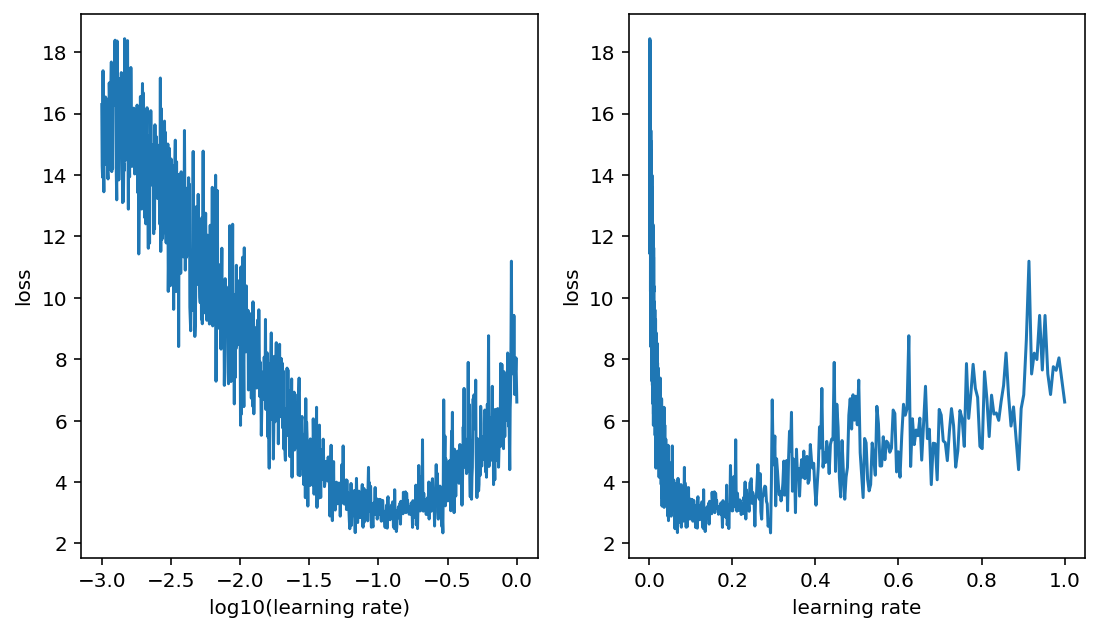

In [32]:
# plot the loss against the learning rate
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].plot(alpha_log_list, loss_list)
ax[0].set_xlabel('log10(learning rate)')
ax[0].set_ylabel('loss')
ax[1].plot(alpha_list, loss_list)
ax[1].set_xlabel('learning rate')
ax[1].set_ylabel('loss')

## Split the dataset into train and test

In [33]:
# split the dataset into training and validation sets and test set
# 80% training, 10% validation, 10% test
n_train = int(len(X) * 0.8)
n_valid = int(len(X) * 0.1)
n_test = len(X) - n_train - n_valid

# shuffle the dataset
idx = torch.randperm(len(X))
X = X[idx]
Y = Y[idx]

# split the dataset

X_train = X[:n_train]
Y_train = Y[:n_train]
X_valid = X[n_train:n_train+n_valid]
Y_valid = Y[n_train:n_train+n_valid]
X_test = X[n_train+n_valid:]
Y_test = Y[n_train+n_valid:]

In [35]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

torch.Size([182516, 3]) torch.Size([182516])
torch.Size([22814, 3]) torch.Size([22814])
torch.Size([22816, 3]) torch.Size([22816])


In [76]:
# train the model

# initialize the parameters
g_seed = torch.Generator().manual_seed(666)
C_lookup = torch.randn(len(char2int), 2, requires_grad=True, generator=g_seed)
W1 = torch.randn(3*2, 100, requires_grad=True, generator=g_seed)
b1 = torch.randn(100, requires_grad=True, generator=g_seed)
W2 = torch.randn(100, len(char2int), requires_grad=True, generator=g_seed)
b2 = torch.randn(len(char2int), requires_grad=True, generator=g_seed)
parameters = [C_lookup, W1, b1, W2, b2]

for _ in range(30000):
    # minibatch
    idx = torch.randint(len(X_train), (32,))
    # forward pass
    loss = forward(X_train[idx], Y_train[idx], *parameters)
    # initialize the gradients
    for p in parameters:
        p.grad = None
    # backpropagation
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data -= 0.1 * p.grad

In [72]:
# print the training loss
# it takes more than 9 seconds to train the model
print(loss.item())

2.340245485305786


In [74]:
# check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

# initialize the parameters
g_seed = torch.Generator().manual_seed(666)
C_lookup = torch.randn(len(char2int), 2, requires_grad=True, generator=g_seed)
W1 = torch.randn(3*2, 100, requires_grad=True, generator=g_seed)
b1 = torch.randn(100, requires_grad=True, generator=g_seed)
W2 = torch.randn(100, len(char2int), requires_grad=True, generator=g_seed)
b2 = torch.randn(len(char2int), requires_grad=True, generator=g_seed)

# move the model parameters and data to the device
C_lookup = C_lookup.to(device)
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)

parameters = [C_lookup, W1, b1, W2, b2]


Training on GPU


In [75]:
for _ in range(30000):
    # minibatch
    idx = torch.randint(len(X_train), (32,))
    # forward pass
    loss = forward(X_train[idx].to(device), Y_train[idx].to(device), C_lookup, W1, b1, W2, b2)
    # initialize the gradients
    for p in parameters:
        p.grad = None

    # backpropagation
    loss.backward()
    # update the parameters
    for p in parameters:
        # retain gradient 
        p.retain_grad()
        if p.grad is not None:
            p.data -= 0.1 * p.grad

In [64]:
# print the training loss
# it takes 14.8 seconds to train the model
print(loss.item())

2.260181188583374


In [70]:
# iteraration = 30000
# batch size = 3200
# GPU: 47.4 seconds
# CPU: 50.6 seconds
# batch size = 32
# GPU: 14.8 seconds
# CPU: 9 seconds

In [77]:
# validation
forward_val = forward(X_valid, Y_valid, *parameters)
print(forward_val.item())

2.3921053409576416


Becasue the trainning loss is smaller than the validation loss, we can say that the model is underfitting. We can try to increase the model complexity by adding more layers or increase the number of hidden units.

In [103]:
# increase the size of the hidden layer
# train the model

# initialize the parameters
g_seed = torch.Generator().manual_seed(666)
C_lookup = torch.randn(len(char2int), 2, requires_grad=True, generator=g_seed)
W1 = torch.randn(3*2, 100, requires_grad=True, generator=g_seed)
b1 = torch.randn(100, requires_grad=True, generator=g_seed)
W2 = torch.randn(100, len(char2int), requires_grad=True, generator=g_seed)
b2 = torch.randn(len(char2int), requires_grad=True, generator=g_seed)
parameters = [C_lookup, W1, b1, W2, b2]

# print out the number of parameters
print(sum([p.numel() for p in parameters]))

# track loss and steps
losses = []
steps = []

for i in range(30000):
    # minibatch
    idx = torch.randint(len(X_train), (32,))
    # forward pass
    loss = forward(X_train[idx], Y_train[idx], *parameters)
    # initialize the gradients
    for p in parameters:
        p.grad = None
    # backpropagation
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data -= 0.01 * p.grad

    # track loss and steps
    steps.append(i)
    losses.append(loss.item())

3481


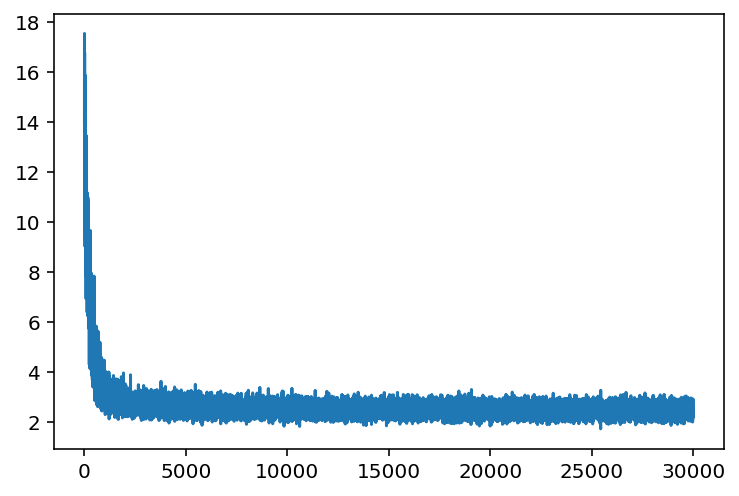

In [104]:
# plot the loss
plt.plot(steps, losses)

In [105]:
# validation
forward_val = forward(X_valid, Y_valid, *parameters)
print(forward_val.item())

2.4546666145324707


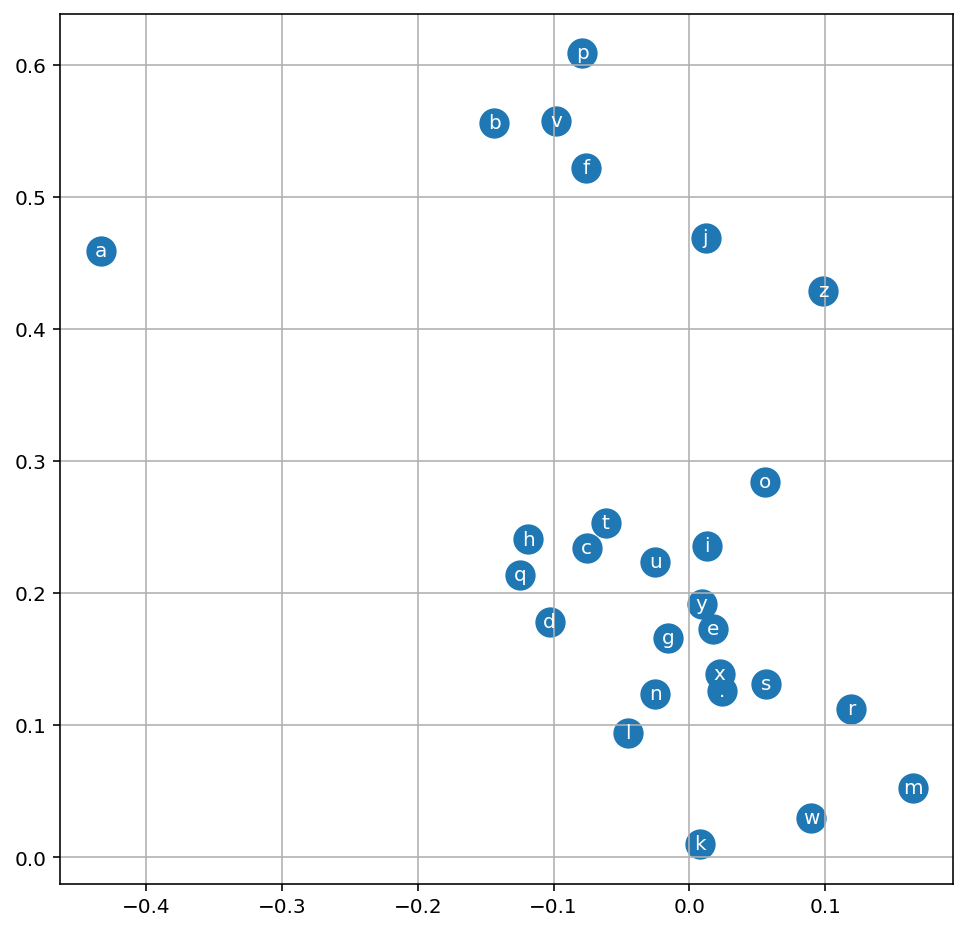

In [106]:
# visualize the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C_lookup[:, 0].data, C_lookup[:, 1].data, s=200)
for i, char in enumerate(char2int):
    plt.text(C_lookup[i, 0], C_lookup[i, 1], char, va='center', ha='center', color='white')
plt.grid('minor')

In [114]:
# scale up 
# increase the size of the hidden layer
# train the model

# initialize the parameters
g_seed = torch.Generator().manual_seed(666)
C_lookup = torch.randn(len(char2int), 10, requires_grad=True, generator=g_seed)
W1 = torch.randn(3*10, 200, requires_grad=True, generator=g_seed)
b1 = torch.randn(200, requires_grad=True, generator=g_seed)
W2 = torch.randn(200, len(char2int), requires_grad=True, generator=g_seed)
b2 = torch.randn(len(char2int), requires_grad=True, generator=g_seed)
parameters = [C_lookup, W1, b1, W2, b2]

# print out the number of parameters
print(sum([p.numel() for p in parameters]))


# forward function
def forward(X, Y, C_lookup, W1, b1, W2, b2):
    # embedding all the characters in the input sequences
    X_embed = C_lookup[X]
    # reshape the input sequences
    X_embed = X_embed.view(-1, 3*10)
    # calculate the hidden layer
    H = torch.tanh(X_embed @ W1 + b1)
    # calculate the output layer
    logits = H @ W2 + b2
    # use coross-entropy loss
    loss = F.cross_entropy(logits, Y)

    return loss

# track loss and steps
losses = []
steps = []

for i in range(80000):
    # minibatch
    idx = torch.randint(len(X_train), (32,))
    # forward pass
    loss = forward(X_train[idx], Y_train[idx], *parameters)
    # initialize the gradients
    for p in parameters:
        p.grad = None
    # backpropagation
    loss.backward()
    # update the parameters
    for p in parameters:
        p.data -= 0.01 * p.grad

    # track loss and steps
    steps.append(i)
    # track the log of the loss
    losses.append(loss.log10().item())

11897


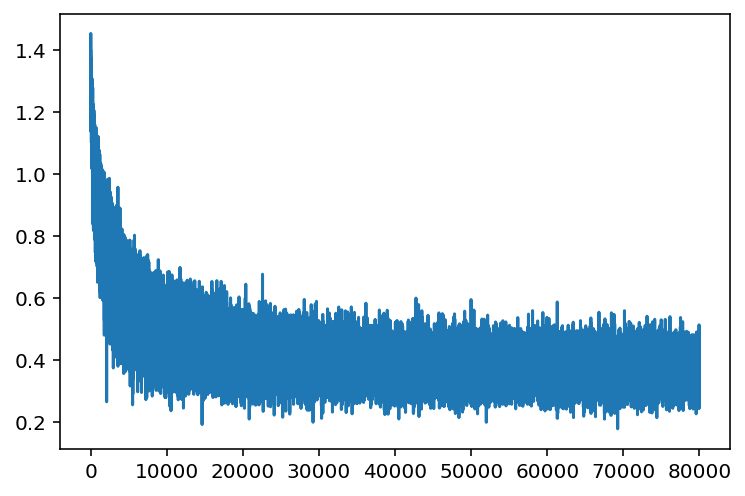

In [115]:
# plot the loss
plt.plot(steps, losses)

In [116]:
# print the last loss
print(loss.item())

2.28985857963562


In [117]:
# validation
forward_val = forward(X_valid, Y_valid, *parameters)
print(forward_val.item())

2.3753321170806885


In [119]:
print(W1.shape)

torch.Size([30, 200])


In [126]:
# sample from the model
g_seed = torch.Generator().manual_seed(777)
for _ in range(20):
    predicts = []
    context = [0] * block_size
    while True:
        # get the embedding of the context
        context_embed = C_lookup[torch.tensor(context)]
        # reshape the context
        context_embed = context_embed.view(-1, 3*10)
        # calculate the hidden layer
        H = torch.tanh(context_embed @ W1 + b1)
        # calculate probabilities of the next character
        probs = F.softmax(H @ W2 + b2, dim=1)
        # sample from the distribution
        next_char = torch.multinomial(probs, num_samples=1, generator=g_seed).item()
        # append the sampled character to the predicts
        predicts.append(next_char)
        # update the context
        context = context[1:] + [next_char]
        if next_char == 0:
            break
    # print the sampled sequence
    print(''.join([int2char[i] for i in predicts[:-1]]))

asyah
yran
nevero
lin
yiv
ada
tzanio
maylon
tolemine
fartreva
blaikalijinie
zowibylla
wylynnyeh
war
mamyene
his
mawsa
jariah
fiye
jamesh


In [130]:
10075 + 46775  + 7125 + 6892 + 5400 + 76820 + 4553

157640